#Final Project

Context
You are a conservation biologist in charge of managing habitats for a protected
reserve. Your reserve includes several distinct patches of intact forest that harbor
populations of the endangered Warbling Babbler. You are worried about the longterm
fate of these populations if the habitats remain disconnected with limited
movement of individuals between them (i.e., limited migration between the
populations), so youʼd like to use funds from your budget to establish habitat
corridors that will allow individuals to move between the patches. However, you also
know that the populations have some phenotypic differences (like color) and you are
wondering how the frequencies of the phenotypes, and the overall population sizes,
will change in the populations once they are connected.


In [52]:
# Import necessary modules
import matplotlib.pyplot as plt
import random
import numpy as np

Your framework will include three types of classes: an Individual class, a Population class, and a Landscape class. Individuals exist in populations, and populations exist in a landscape. In each time step of your simulation, individuals can stay in the population where they started, or move to a
new population. The probabilities that individuals stay or leave are stored in a table called a dispersal matrix (more detail below).

In [54]:
class Individual:
    """Class to hold information on indiviuals."""
    def __init__(self, id, phenotype):
        """The constructor for the individual class, with id and phenotype as attributes."""
        self.id = id
        self.phenotype = phenotype

Population constructors should create a new list for individuals in that population,
and Populations should have methods to add and remove individuals, as well as to
calculate and print the frequency of phenotypes among individuals.

In [64]:
class Population:
    """Class to hold information on populations that is composed of individuals."""
    def __init__(self, id, popSize, phenotype): 
        """"The constructor for the population class."""
        self.id = id
        self.individuals = [] #create a list of individuals
        for i in range(popSize):
            self.individuals.append(Individual("%s-%d" % (id, i+1), phenotype)) #loop through the population to add individuals

    def addIndividual(self, individual):
        """A function that adds individuals to a list."""
        self.individuals.append(individual)
    
    def removeIndividual(self, individual):
        """A function that removes individuals from a list."""
        try:
            self.individuals.remove(individual)
        except ValueError: #allows the function to work despite errors
            pass
    
    def calculateFreq(self, phenotype):
        """This function calculates the frequency of phenotypes found in a population."""
        freq = 0 
        popSize = len(self.individuals)
        for ind in self.individuals: 
             if ind.phenotype == phenotype: #if phenotype in the list of individuals is equal to the given phenotype, then increase frequency by 1
                 freq = freq + 1
        if popSize > 0:
            phenoFreq = float(freq/popSize) * 100
        else:
            phenoFreq = 0
        return phenoFreq
    
    def printFreq(self, phenotype): #useful in testing of the code
        """Function to print out the phenotype and its frequency."""
        print("The %s phenotype frequency is %d" % (phenotype, self.calculateFreq(phenotype))) #calls the previous calculateFreq function

Landscape constructors should create a new list for the populations in that landscape, and Landscapes should have a method that uses the probabilities in the dispersal matrix to determine if an individual moves or stays each time step. Either the Population or Landscape constructors should set the starting population sizes. The total number of individuals across all populations should stay constant, but individual populations may change size.

In [65]:
class Landscape:
    """Class to hold information on landscapes, which are composed of different populations, which in turn have different individuals."""
    def __init__(self, popSize=10, phenotypes=None, dispersalMatrix=None, simulationSteps=1): 
        """"The constructor for the Landscape class, taking population size, the different phenotypes, a dispersal matrix, and number of time steps as arguments."""
        self.dispersalMatrix = dispersalMatrix
        self.simulationSteps = simulationSteps
        self.phenotypes = phenotypes
        self.popSizeRecords = [[popSize] * len(phenotypes)] #records popSize for step zero
        self.phenoFreqRecords = [[]] #list in a list to keep a record of changes in phenotype frequencies throughout simulation steps.
        self.populations = []
        for i in range(len(phenotypes)): #iterate through the populations since number of populations corresponds to number of phenotypes
            self.populations.append(Population('pop%s' % chr(65 + i), popSize, phenotypes[i]))
            popPhenoFreq = [0] * len(phenotypes) #creates a list of phenotypic frequencies, by default starting with zeros
            popPhenoFreq[i] = popSize #sets phenotype frequency equal to popsize for a specific phenotype for the first stage of simulation
            self.phenoFreqRecords[0].append(popPhenoFreq)     
    
    def migratePop(self):
        """Function to move individuals from one population to another, with the probability that the individual moves based on the inputted dispersal matrix."""
        migrationRecords = {} #dictionary to retain info about migrations
        for i in range(len(self.populations)): #loop through the list of populations
            popSize = len(self.populations[i].individuals)  
            probWeights = self.dispersalMatrix[i] 
            popIndexList = list(range(0, len(self.populations)))
            migrationMap = random.choices(popIndexList, weights=probWeights, k=popSize) #randomly selects destination pop from the popIndex list, weights from dispersal matrix 
            sourcePopId = self.populations[i].id #list for source pops
            
            for indIndex, destPopIndex in enumerate(migrationMap): #obtains index and value of migrationMap
                if destPopIndex != i:
                    migrant = self.populations[i].individuals[indIndex] #identify the individual as a migrant if destination pop is different than source
                    #if source population is in the migration Record dictionary, then append it to the dictionary, otherwise, create a new entry in the dictionary
                    if sourcePopId in migrationRecords:
                        migrationRecords[sourcePopId].append({'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}) 
                    else:
                        migrationRecords[sourcePopId] = [{'migrant': migrant, 'destPopIndex': destPopIndex, 'sourcePopIndex': i}]
        
        for pop in migrationRecords: 
            for record in migrationRecords[pop]: #for each of the populations, then loop through each of the records
                sourcePopIndex = record['sourcePopIndex']
                destPopIndex = record['destPopIndex']
                migrant = record['migrant']
                #migrant is added to destination population and removed from source population using functions from Population class
                self.populations[destPopIndex].addIndividual(migrant)
                self.populations[sourcePopIndex].removeIndividual(migrant)
       #store these values at the end after the migration has occurred
        self.storePopSize()
        self.storePhenoFreq()
           
    def storePopSize(self):
        """Store population size per simulation step to facilitate plotting."""
        tempPopSizeRecords = []
        for pop in self.populations:
            tempPopSizeRecords.append(len(pop.individuals)) #temporarily store population sizes for each population before appending to final popSizeRecords list
        self.popSizeRecords.append(tempPopSizeRecords)

    def storePhenoFreq(self):
        """Store phenotype frequencies per simulation step to facilitate plotting."""
        tempPhenoFreqRecords = []
        for pop in self.populations:
            for phenoIndex, pheno in enumerate(self.phenotypes):
                if phenoIndex < len(tempPhenoFreqRecords): #append phenotype frequencies according to whether the temporary list is empty or not
                    tempPhenoFreqRecords[phenoIndex].append(pop.calculateFreq(pheno))
                else:
                    tempPhenoFreqRecords.append([pop.calculateFreq(pheno)])
        self.phenoFreqRecords.append(tempPhenoFreqRecords) #attach temporary list to the function called by the object

    def startSimulation(self):
        """Function that will call how many times steps the simulation should be run for."""
        for i in range(self.simulationSteps):
            print('Simulating step %d...' % (i+1))
            self.migratePop() #call function to initiate the migration
        print('Simulation complete.')
   
    def plotPopSizes(self):
        """Function to plot the summary of populations per simulation stage."""
        xValues = list(range(0, self.simulationSteps + 1))
        transPopSizeRecords = np.array(self.popSizeRecords).T.tolist() #transpose the values in order to plot them according to population
        # Setting up the plot
        plt.title("Population Size Changes") 
        plt.ylabel("Population (individuals)")
        plt.xlabel("Simulation Step")

        for popIndex, yValues in enumerate(transPopSizeRecords):
            plt.plot(xValues, yValues, marker="o", label=self.populations[popIndex].id) #line plot using the xaxis from above and yaxis is value from transposed list
        
        plt.locator_params(axis="both", integer=True, tight=True) #this creates tick marks on both axes
        plt.margins(0.05)
        plt.legend() #need to establish labels above for legend to work
        plt.show()
    
    def plotPhenoFreq(self):
        """Function to plot the total phenotypes per populations per simulation stage."""
        # Generating frequency data
        xValues = list(range(0, self.simulationSteps + 1))
        transPhenoFreqRecords = np.array(self.phenoFreqRecords).T.tolist() #transpose the values in order to plot them according to population

        for phenoIndex, pheno in enumerate(self.phenotypes): #set up a separate plot for each phenotype
            plt.title("Phenotype '%s' Frequency Changes" % pheno) #use phenotype of choice as the plot title
            plt.ylabel("Percentage")
            plt.xlabel("Simulation Step")

            for popIndex, pop in enumerate(transPhenoFreqRecords):
                yValues = pop[phenoIndex] #get phenotype values as the y values
                plt.plot(xValues, yValues, marker="o", label=self.populations[popIndex].id)  #xaxis as number of simulation steps, yValues are total # of each phenotype 
            
            plt.locator_params(axis="both", integer=True, tight=True) #add tick marks to both axes
            plt.margins(0.05)
            plt.legend()
            plt.show()    

    def plotPhenoSummary(self):
        """Function to plot the distribution of phenotypes per population in the last simulation stage."""
        labels = self.phenotypes
        for pop in self.populations: #plot it per population
            popSummary = []
            # Setting up the plot
            plt.title("Phenotype Distribution for %s" % pop.id) 
            for pheno in self.phenotypes:
                popSummary.append(pop.calculateFreq(pheno)) #calculate the frequency of each phenotype for the last stage

            plt.pie(popSummary, labels=labels, autopct=lambda p : '{:.1f}%({:,.0f})'.format(p,p * sum(popSummary)/100), shadow=True, startangle=140)
            plt.axis('equal')
            plt.show()

    def printLandscapeStatus(self):
        """Function to print last status of Landscape status, useful for testing purposes."""
        print('\nFinal landscape status:')
        for pop in self.populations: #iterate through the populations
            print('Population: %s' % pop.id)
            for ind in pop.individuals:
                print('%s => %s' % (ind.id, ind.phenotype))


Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulation complete.


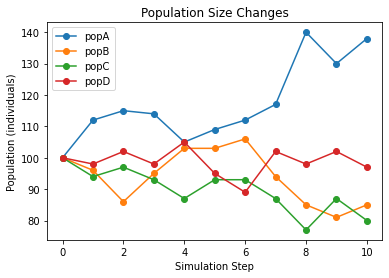

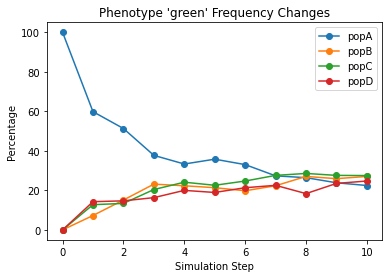

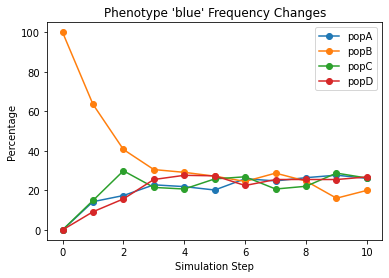

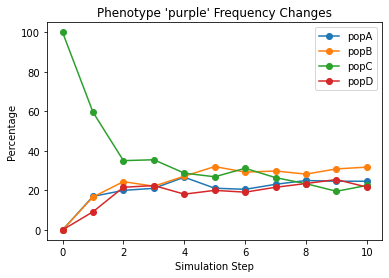

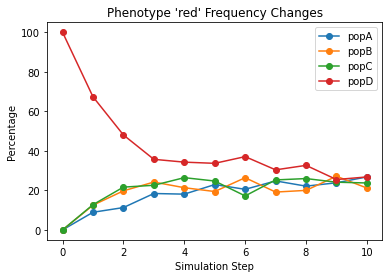

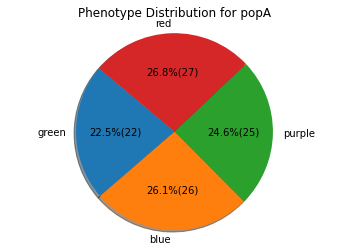

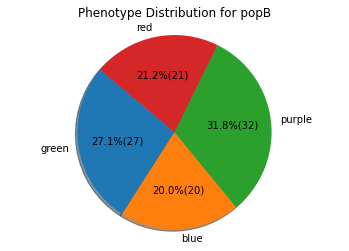

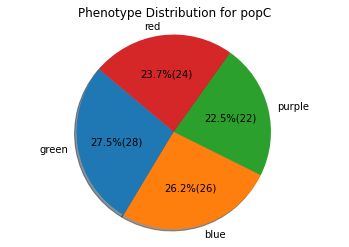

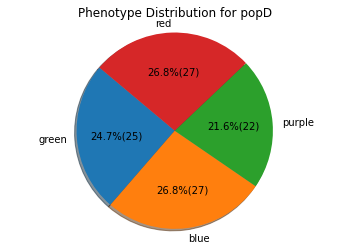

In [57]:
phenotypes = ['green', 'blue', 'purple', 'red']
dispersalMatrix = [ #the matrix needs to equal the number of populations, established by the number of phenotypes provided (as colors)
    [0.7, 0.1, 0.1, 0.1],
    [0.1, 0.6, 0.2, 0.1],
    [0.2, 0.2, 0.5, 0.1],
    [0.1, 0.1, 0.1, 0.7]]
steps = 10 #(this indicates the number of time steps for the simulation)
popSize = 100 

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps) #store the values in this way so easier to change them above rather than when running the simulation
testLandscape.startSimulation()
#call the plotting functions:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

Question 1: How do the frequencies of phenotypes change in each population week-by-week as individuals move?

After running several simulations, it is apparent that the frequencies of phenotypes initially vary, but in the end all frequencies converge. In other words, after several time-steps, the populations end up having an equal distribution of each phenotype. This is very apparent when there are three phenotypes and after 10 time steps, the distribution of each phenotype is about 33% (so a third) in each populations (see pie charts outputted by the simulation found below.)

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulation complete.


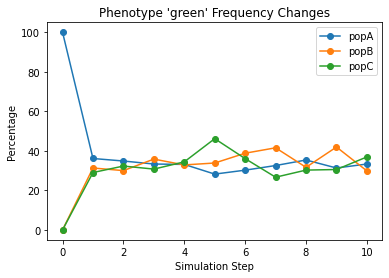

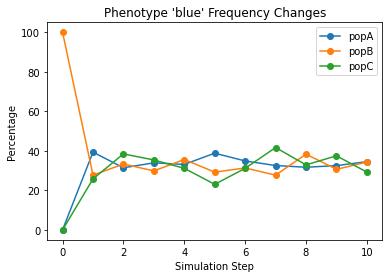

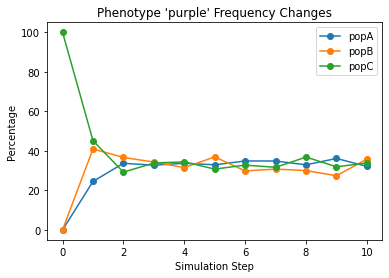

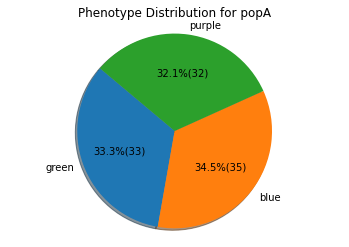

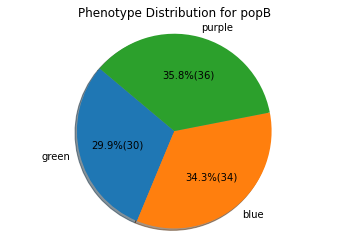

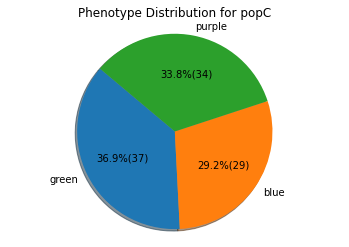

In [58]:
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [
    [0.6, 0.2, 0.2],
    [0.6, 0.3, 0.2],
    [0.4, 0.3, 0.3]
    ]
steps = 10
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

Question 2: What effect does an overall increase in the rate of movement (migration) have?

After running a low migration and high migration dispersal matrices several times (see below for example), it could be seen that population size fluctuated in both cases, but the changes from one step to another were more extreme for the high migration model. This makes sense since in the first model, if a migrant moves to one population, he is less likely to move again and will most likely stay put, but in the case of high migration, it is more fluid situation with many individuals constantly moving in and out of populations. 

As for the effect of migration on phenotypic frequencies, as stated in the previous answer, phenotypic frequencies tend to converge (i.e. reach equilibrium) no matter the model type, but the pattern in reaching convergence differs on whether there is low migration or high migration. In the case of low migration, there is less variation in phenotypic frequencies and so they take longer to converge (at about simulation step 7 or 10) but it is more stable. With high migration, there is more variation in the phenotypic frequencies per time step, so it reaches convergence faster than in the case of low migration, reaching convergence by step 2 or 3. However, since it exhibits an oscillating convergence, it is not as stable as low convergence, and by the last time steps there is still the possibility that it the frequencies are varying away from convergence. This is because phenotype frequencies vary more quickly since there are higher rates of migrants bringing in and removing phenotypes from a population.

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulating step 30...
Simulating step 31...
Simulating step 32...
Simulating step 33...
Simulating step 34...
Simulating step 35...
Simulating step 36...
Simulating step 37...
Simulating step 38...
Simulating step 39...
Simulating step 40...
Simulating step 41...
Simulating step 42...
Simulating step 43...
Simulating step 44...
Simulating step 45...
Simulating step 46.

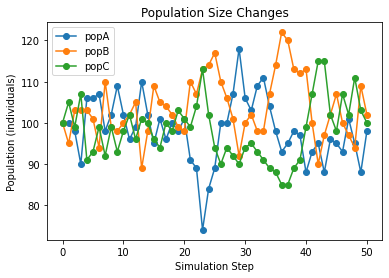

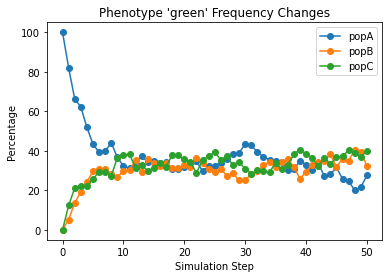

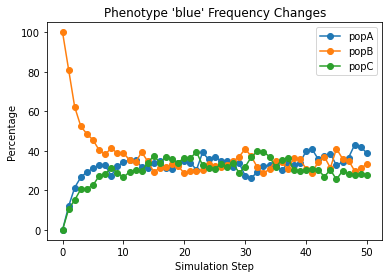

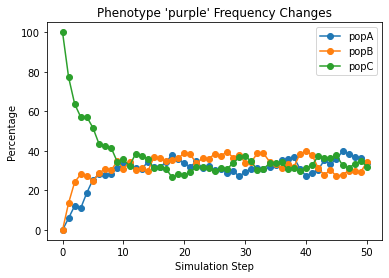

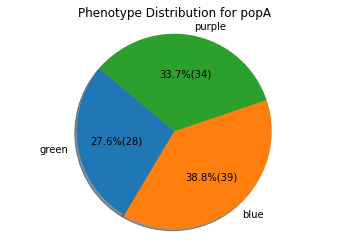

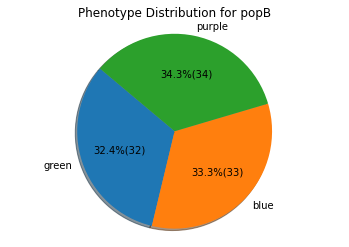

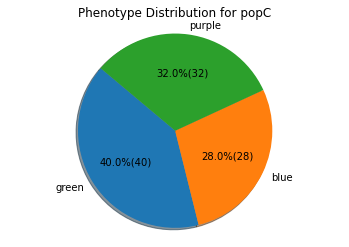

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulating step 30...
Simulating step 31...
Simulating step 32...
Simulating step 33...
Simulating step 34...
Simulating step 35...
Simulating step 36...
Simulating step 37...
Simulating step 38...
Simulating step 39...
Simulating step 40...
Simulating step 41...
Simulating step 42...
Simulating step 43...
Simulating step 44...
Simulating step 45...
Simulating step 46.

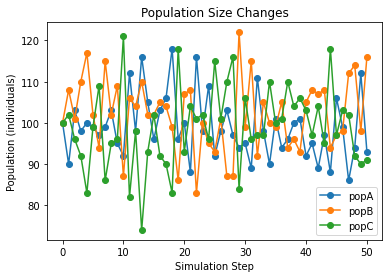

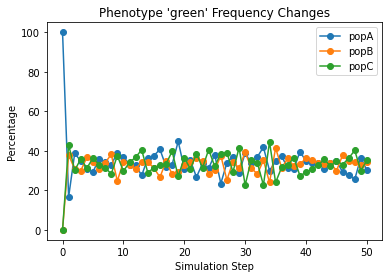

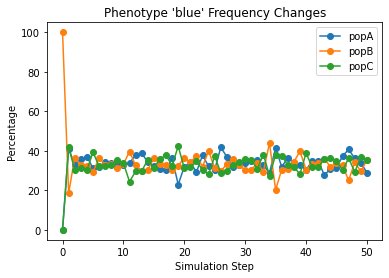

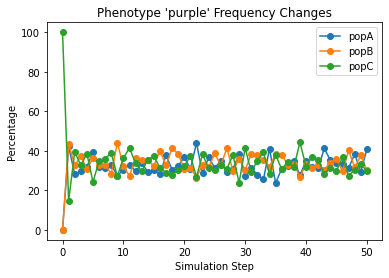

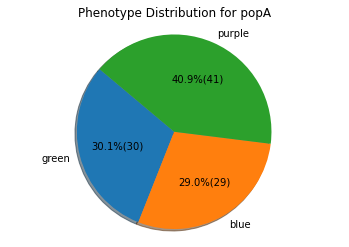

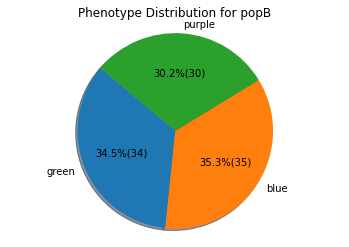

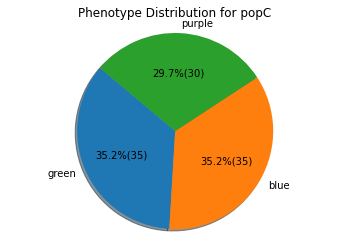

In [59]:
###Low Migration###
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]
    ]
steps = 50
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

###High Migration###
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [
    [0.2, 0.4, 0.4],
    [0.4, 0.2, 0.4],
    [0.4, 0.4, 0.2]]
    
steps = 50
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

Question 3: What happens to both phenotype frequencies and population sizes when movement probabilities are not symmetric (individuals have a higher probability of moving from population A to population B, than they do of moving from population B to population A)?

When there is asymmetric migration into one population, the destination population explodes in population size after the first time step and remains relatively high despite minor poulation size fluctuations, while the source population crashes in population size after the first time step and then despite minor changes in size, remains relatively low. This pattern is more drastic when there is a higher probability of natives of the destination population remaining. 

As for phenotypic frequencies, in the first time step each population is characterized by a certain phenotype, i.e. PopA has 100 red individuals and 0 blue, while PopB has 0 red individuals and 100 blue, but the destination population (popB) receives an influx of the migrants' phenotype after the first time step. This makes the growing PopB accept red individuals as well as keep its blue individuals, to ultimately result in reaching distribution equilibrium between the two phenotypes (i.e. the pie charts show each population is composed of an equal number of red and blue phenotypes.)

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulating step 30...
Simulating step 31...
Simulating step 32...
Simulating step 33...
Simulating step 34...
Simulating step 35...
Simulating step 36...
Simulating step 37...
Simulating step 38...
Simulating step 39...
Simulating step 40...
Simulating step 41...
Simulating step 42...
Simulating step 43...
Simulating step 44...
Simulating step 45...
Simulating step 46.

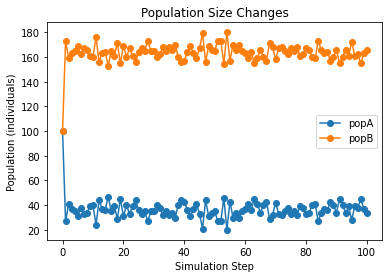

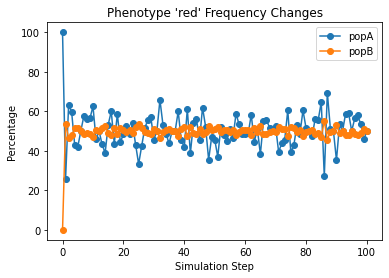

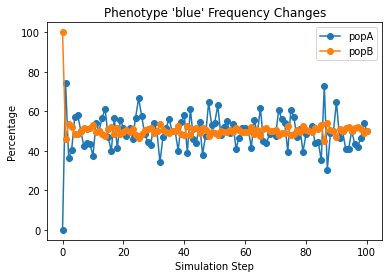

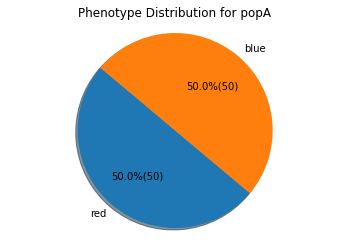

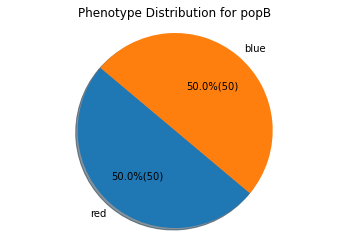

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...
Simulating step 9...
Simulating step 10...
Simulating step 11...
Simulating step 12...
Simulating step 13...
Simulating step 14...
Simulating step 15...
Simulating step 16...
Simulating step 17...
Simulating step 18...
Simulating step 19...
Simulating step 20...
Simulating step 21...
Simulating step 22...
Simulating step 23...
Simulating step 24...
Simulating step 25...
Simulating step 26...
Simulating step 27...
Simulating step 28...
Simulating step 29...
Simulating step 30...
Simulating step 31...
Simulating step 32...
Simulating step 33...
Simulating step 34...
Simulating step 35...
Simulating step 36...
Simulating step 37...
Simulating step 38...
Simulating step 39...
Simulating step 40...
Simulating step 41...
Simulating step 42...
Simulating step 43...
Simulating step 44...
Simulating step 45...
Simulating step 46.

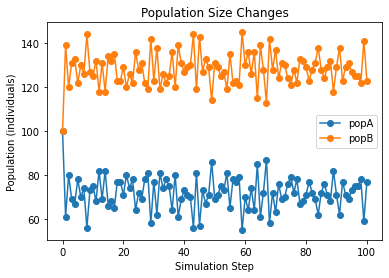

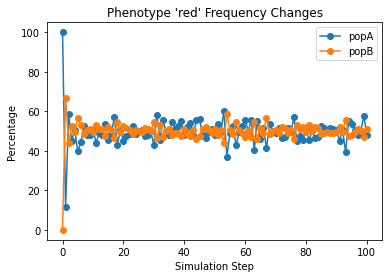

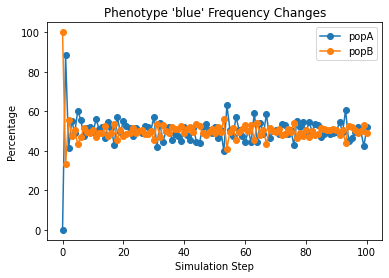

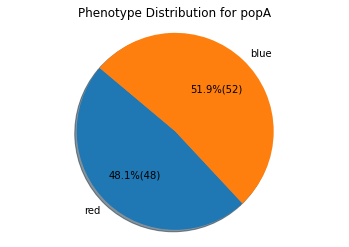

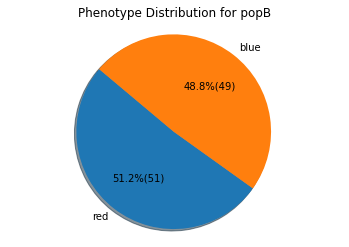

In [62]:
###Non-symmetric movement probabilities###
#Movement into pop B from pop A with most of pop B staying in their population
phenotypes = ['red', 'blue']
dispersalMatrix = [
    [0.1, 0.9],
    [0.2, 0.8],
    ]
steps = 100
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

###Non-symmetric movement probabilities###
#Movement into pop B from pop A with an equal probability of individuals to stay or leave PopB
phenotypes = ['red', 'blue']
dispersalMatrix = [
    [0.1, 0.9],
    [0.5, 0.5],
    ]
steps = 100
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPopSizes()
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

Question 4: What effect does changing the starting population sizes have on the trajectory of phenotype frequencies? In other words, what might happen if you connect big habitat patches versus small habitat patches?

In [63]:
###Small Pops###
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [
    [0.6, 0.2, 0.2],
    [0.6, 0.3, 0.2],
    [0.4, 0.3, 0.3]
    ]
steps = 10
popSize = 5

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

###Big Pops###
phenotypes = ['green', 'blue', 'purple']
dispersalMatrix = [
    [0.6, 0.2, 0.2],
    [0.6, 0.3, 0.2],
    [0.4, 0.3, 0.3]
    ]
steps = 10
popSize = 100

testLandscape = Landscape(popSize, phenotypes, dispersalMatrix, steps)
testLandscape.startSimulation()
#plotting:
testLandscape.plotPhenoFreq()
testLandscape.plotPhenoSummary()

Simulating step 1...
Simulating step 2...
Simulating step 3...
Simulating step 4...
Simulating step 5...
Simulating step 6...
Simulating step 7...
Simulating step 8...


ZeroDivisionError: division by zero